In [14]:
import mujoco
import mujoco_viewer
import matplotlib.pyplot as plt
import numpy as np
import os
from lxml import etree
import mujoco.viewer
import time


In [82]:
xml = "xml.xml"
model = mujoco.MjModel.from_xml_path("xml.xml")
data = mujoco.MjData(model)





In [83]:
# ПРОВЕРКА СЕНСОРОВ И ТЕНДОНОВ
print("=== ПРОВЕРКА СЕНСОРОВ ===")
print(f"Всего сенсоров: {model.nsensor}")

for i in range(model.nsensor):
    name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_SENSOR, i)
    print(f"Сенсор {i}: {name} = {data.sensordata[i]}")

print(f"\n=== ПРОВЕРКА ТЕНДОНОВ ===")
print(f"Всего тендонов: {model.ntendon}")
for i in range(model.ntendon):
    name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_TENDON, i)
    length = data.ten_length[i]
    print(f"Тендон {i}: {name}, длина: {length}")

print(f"\n=== ПРОВЕРКА ID ===")
tendon1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_TENDON, "Tendon1")
tendon2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_TENDON, "Tendon2")
print(f"Tendon1 ID: {tendon1_id}")
print(f"Tendon2 ID: {tendon2_id}")

=== ПРОВЕРКА СЕНСОРОВ ===
Всего сенсоров: 5
Сенсор 0: None = 0.0
Сенсор 1: q1 = 0.0
Сенсор 2: dq1 = 0.0
Сенсор 3: q2 = 0.0
Сенсор 4: dq2 = 0.0

=== ПРОВЕРКА ТЕНДОНОВ ===
Всего тендонов: 2
Тендон 0: Tendon1, длина: 0.0
Тендон 1: Tendon2, длина: 0.0

=== ПРОВЕРКА ID ===
Tendon1 ID: 0
Tendon2 ID: 1


  0: None = 0.189
  1: q1 = 0.0
  2: dq1 = 0.0
  3: q2 = 0.0
  4: dq2 = 0.0
Joint1: pos=-0.000, vel=-39.954, ctrl=95.900
Joint2: pos=-0.000, vel=749.784, ctrl=-442.236
Joint1: pos=-0.000, vel=-39.954, ctrl=96.059
Joint2: pos=-0.000, vel=749.784, ctrl=-442.115
Joint1: pos=-0.000, vel=-39.954, ctrl=96.217
Joint2: pos=-0.000, vel=749.784, ctrl=-441.993
Joint1: pos=-0.000, vel=-39.954, ctrl=96.376
Joint2: pos=-0.000, vel=749.784, ctrl=-441.871
Joint1: pos=-0.000, vel=-39.954, ctrl=96.534
Joint2: pos=-0.000, vel=749.784, ctrl=-441.749
Joint1: pos=-0.000, vel=-39.954, ctrl=96.693
Joint2: pos=-0.000, vel=749.784, ctrl=-441.628
Joint1: pos=-0.000, vel=-39.954, ctrl=96.851
Joint2: pos=-0.000, vel=749.784, ctrl=-441.506
Joint1: pos=-0.000, vel=-39.954, ctrl=97.010
Joint2: pos=-0.000, vel=749.784, ctrl=-441.384
Joint1: pos=-0.000, vel=-39.954, ctrl=97.168
Joint2: pos=-0.000, vel=749.784, ctrl=-441.262
Joint1: pos=-0.000, vel=-39.954, ctrl=97.327
Joint2: pos=-0.000, vel=749.784, ctrl=-441.141
Join

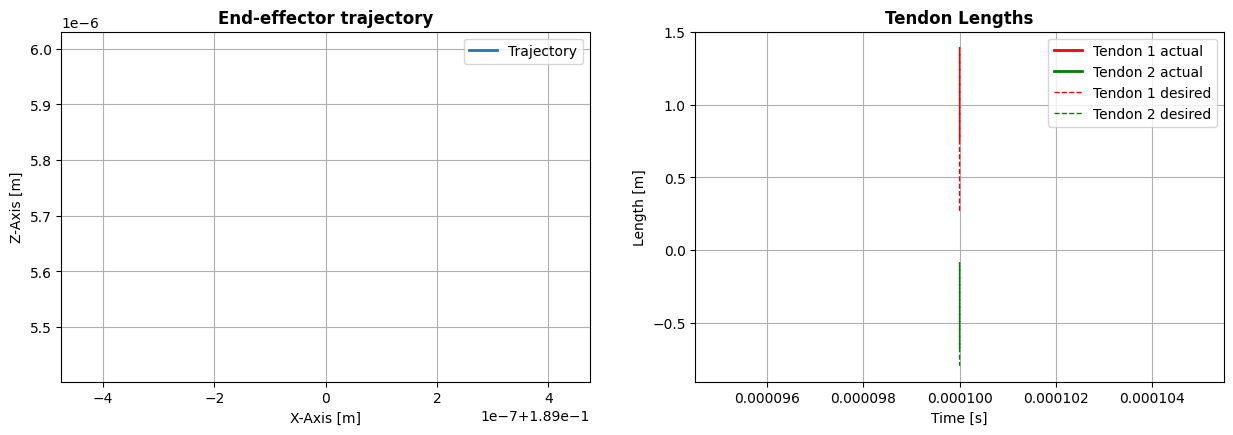

In [80]:
SIMEND = 20
TIMESTEP = 0.001
STEP_NUM = int(SIMEND / TIMESTEP)
timeseries = np.linspace(0, SIMEND, STEP_NUM)
# 36.33	2.5	43.5	33.54	2.08	-0000386
A1 = np.deg2rad(36.33)
A2 = np.deg2rad(33.54)
F1 = 2.5
F2 = 2.08
B1 = np.deg2rad(43.5)
B2 = np.deg2rad(-38.6)
q_d1 = A1 * np.sin(F1 * timeseries) + B1
q_d2 = A2 * np.sin(F2 * timeseries) + B2

EE_position_x = []
EE_position_z = []
tendon1_lengths = []
tendon2_lengths = []
joint1_velocities = []
joint2_velocities = []
desired_positions = []
control_signals_1 = []
control_signals_2 = []
simulation_times = []

EE_position_x = []
EE_position_z = []


site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "carriage")
joint1_pos_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "q1")
joint2_pos_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "q2")
joint1_vel_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "dq1")
joint2_vel_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "dq2")

def set_torque(mj_data, KP, KV, q_desired):
    joint1_pos = mj_data.qpos[0]  # joint A
    joint2_pos = mj_data.qpos[1]  # joint B
    joint1_vel = mj_data.qvel[0]
    joint2_vel = mj_data.qvel[1]
    mj_data.ctrl[0] = KP[0] * (q_desired[0] - mj_data.qpos[0]) + KV[0] * (0 - mj_data.qvel[0])
    mj_data.ctrl[1] = KP[1] * (q_desired[1] - mj_data.qpos[1]) + KV[1] * (0 - mj_data.qvel[1])

    print(f"Joint1: pos={joint1_pos:.3f}, vel={joint1_vel:.3f}, ctrl={mj_data.ctrl[0]:.3f}")
    print(f"Joint2: pos={joint2_pos:.3f}, vel={joint2_vel:.3f}, ctrl={mj_data.ctrl[1]:.3f}")

KP = [100, 100]  # Пропорциональные коэффициенты для двух тендонов
KV = [0.5, 0.5]    # Дифференциальные коэффициенты для двух тендонов

completed_steps = 0

viewer = mujoco_viewer.MujocoViewer(model, 
                                    data,
                                    title="2R", 
                                    width=1920, 
                                    height=1080)

for i in range(model.nsensor):
    name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_SENSOR, i)
    value = data.sensordata[i]
    print(f"  {i}: {name} = {value}")

for i in range(STEP_NUM):
    if viewer.is_alive:
       
        set_torque(data, KP, KV, [q_d1[i], q_d2[i]])

        position_EE = data.site_xpos[site_id]

        EE_position_x.append(position_EE[0])
        EE_position_z.append(position_EE[2])
        tendon1_lengths.append(data.sensordata[joint1_pos_id])
        tendon2_lengths.append(data.sensordata[joint2_pos_id])
        simulation_times.append(data.time)

        mujoco.mj_step(model, data)
        viewer.render()
        completed_steps += 1

    else:
        break
viewer.close()

q_d1_completed = q_d1[:completed_steps]
q_d2_completed = q_d2[:completed_steps]
midlength = int(STEP_NUM/2)

# Построение графиков с использованием фактических данных симуляции
plt.figure(figsize=(15, 10))

# График 1: Траектория конечного эффектора
plt.subplot(2, 2, 1)
plt.plot(EE_position_x, EE_position_z, '-', linewidth=2, label='Trajectory')
plt.title('End-effector trajectory', fontsize=12, fontweight='bold')
plt.xlabel('X-Axis [m]')
plt.ylabel('Z-Axis [m]')
plt.axis('equal')
plt.grid()
plt.legend()

# График 2: Длины тендонов (используем simulation_times вместо timeseries)
plt.subplot(2, 2, 2)
plt.plot(simulation_times, tendon1_lengths, 'r-', linewidth=2, label='Tendon 1 actual')
plt.plot(simulation_times, tendon2_lengths, 'g-', linewidth=2, label='Tendon 2 actual')
plt.plot(simulation_times, q_d1_completed, 'r--', linewidth=1, label='Tendon 1 desired')
plt.plot(simulation_times, q_d2_completed, 'g--', linewidth=1, label='Tendon 2 desired')
plt.title('Tendon Lengths', fontsize=12, fontweight='bold')
plt.xlabel('Time [s]')
plt.ylabel('Length [m]')
plt.grid()
plt.legend()



